(chapter2_part1)=

# K-Nearest Neighbors Classifier

- This is a supplement material for the [Machine Learning Simplified](https://themlsbook.com) book. It sheds light on Python implementations of the topics discussed while all detailed explanations can be found in the book. 
- I also assume you know Python syntax and how it works. If you don't, I highly recommend you to take a break and get introduced to the language before going forward with my code. 
- This material can be downloaded as a Jupyter notebook (Download button in the upper-right corner -> `.ipynb`) to reproduce the code and play around with it. 

Let's recall Chapter 2. We have a hypothetical dataset (Table 2.1) containing 20 fruits that are a mix of `apples`, `mandarins`, and `lemons` For each fruit, we have measured it’s `height` and `width` and recorded them as the first two columns of the table. For each fruit we know its `type`, or class label, and this is represented by the last column.

| height | width | fruit |
| ----------- | ----------- | ----------- |
| 3.91 | 5.76 | Mandarin |
| 7.09 | 7.69 | Apple |
| 10.48 | 7.32 | Lemon |
| 9.21 | 7.20 | Lemon |
| 7.95 | 5.90 | Lemon |
| 7.62 | 7.51 | Apple |
| 7.95 | 7.51 | Apple |
| 8.42 | 5.32 | Mandarin |
| 4.69 | 6.19 | Mandarin |
| 7.50 | 5.99 | Lemon |
| 7.11 | 7.02 | Apple |
| 4.15 | 5.60 | Mandarin |
| 7.29 | 8.38 | Apple |
| 8.49 | 6.52 | Lemon |
| 7.44 | 7.89 | Apple |
| 7.86 | 7.60 | Apple |
| 3.93 | 6.12 | Apple |
| 4.40 | 5.90 | Mandarin |
| 8.10 | 6.15 | Lemon |
| 8.69 | 5.82 | Lemon |

The structure of this notebook is identical to the structure of Chapter 2.1: ML Pipeline: Example.

1. Problem Representation
2. Learning a Prediction Function
3. How Good is our Prediction Function?
4. Model Complexity

## 1. Required Libraries & Functions

In [1]:
# Libraries
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
%config InlineBackend.figure_format = 'retina' # sharper plots


# Create a function to plot scatter graph
def plotFruitFigure():
    # Define variables for graph
    apple_height, apple_width = df.height[df.fruit == 'Apple'], df.width[df.fruit == 'Apple']
    mandarin_height, mandarin_width = df.height[df.fruit == 'Mandarin'], df.width[df.fruit == 'Mandarin']
    lemon_height, lemon_width = df.height[df.fruit == 'Lemon'], df.width[df.fruit == 'Lemon']

    # Initialize the graph
    fig, ax = plt.subplots()
    plt.gca().set_aspect('equal', adjustable='box')

    # Plot defined variables on it
    ax.plot(apple_height, apple_width, 'o', color='r', label='apple')
    ax.plot(mandarin_height, mandarin_width, 'o', color='g', label='mandarin')
    ax.plot(lemon_height, lemon_width, 'o', color='b', label='lemon')

    # Show legend and configure graph's size
    plt.legend()
    plt.ylim(3, 10) 
    plt.xlim(3, 11)
    plt.title('KNN Fruits Scatter Plot')
    plt.xlabel("height")
    plt.ylabel("width") 
    
# Create a function to plot KNN's decision regions
def plotKNN(
    n_neighbors=int, 
            plot_data=True,
            plot_height=None,
            plot_width=None,
            plot_labels=None):
    
    # Turn categorical target variable into numerical to make a graph
    X = df[['height', 'width']].values
    y_encoded = df["fruit"].astype('category').cat.codes #encoded y

    # Create color maps for graph
    cmap_light = ListedColormap(['pink', 'lightblue', 'lightgreen'])
    cmap_bold = ['green', 'red', 'blue']

    # We want to visualize KNN with 1 nearest neighbor.
    # Let's initialize the model and train it with the dataset
    clf = KNeighborsClassifier(n_neighbors = n_neighbors)
    clf.fit(X, y_encoded)

    # Plot the decision boundary. For that, we will assign a color to each point in the mesh
    x_min, x_max = X[:, 0].min() - 3, X[:, 0].max() + 3
    y_min, y_max = X[:, 1].min() - 3, X[:, 1].max() + 3

    h = .02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=cmap_light)
    
    if plot_data==True:
        # Plot also the dataset observations
        sns.scatterplot(x=plot_height, 
                        y=plot_width,#y=X[:, 1], 
                        hue=plot_labels,#df.fruit.values,
                        palette=cmap_bold, 
                        alpha=1.0, 
                        edgecolor="black")

    # Configure the graph
    plt.ylim(3, 10) 
    plt.xlim(3, 11)
    plt.gca().set_aspect('equal', adjustable='box')

    plt.title(f'KNN Fruits Classifier, n={n_neighbors}')
    plt.xlabel("height")
    plt.ylabel("width")  

## 2. Probelm Representation

### 2.1. Create Hypothetical Dataset

To create a table, we use `pandas` library - a library that manages **PAN**el **DA**ta **S**ets. We have already loaded it in the beginning of this notebook.

In [2]:
# Create a hypothetical dataset from the MLS book
data = {'height': [3.91, 7.09, 10.48, 9.21, 7.95, 7.62, 7.95, 4.69, 7.50, 7.11, 4.15, 7.29, 8.49, 7.44, 7.86, 3.93, 4.40, 5.5, 8.10, 8.69], 
        'width': [5.76, 7.69, 7.32, 7.20, 5.90, 7.51, 5.32, 6.19, 5.99, 7.02, 5.60, 8.38, 6.52, 7.89, 7.60, 6.12, 5.90, 4.5, 6.15, 5.82],
        'fruit': ['Mandarin', 'Apple', 'Lemon', 'Lemon', 'Lemon', 'Apple', 'Mandarin', 'Mandarin', 'Lemon', 'Apple', 'Mandarin', 'Apple', 'Lemon', 'Apple', 'Apple', 'Apple', 'Mandarin', 'Lemon', 'Lemon', 'Lemon']
       }  

# Create DataFrame df using pandas library
df = pd.DataFrame(data)  
  
# Print the output
df


,height,width,fruit
0,3.91,5.76,Mandarin
1,7.09,7.69,Apple
2,10.48,7.32,Lemon
3,9.21,7.20,Lemon
4,7.95,5.90,Lemon
5,7.62,7.51,Apple
6,7.95,5.32,Mandarin
7,4.69,6.19,Mandarin
8,7.50,5.99,Lemon
9,7.11,7.02,Apple


### 2.2. Visualize the Dataset

Let's now make the same graph that we had in the book. We can do so by simply calling the funtion `plotFruitFigure()` that we defined in the beginning.

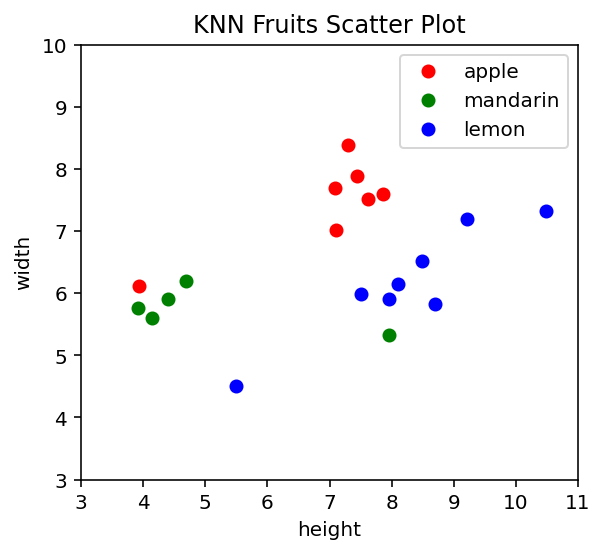

In [3]:
plotFruitFigure()

## 3. Learning a Prediction Function

### 3.1. Build a KNN Classifier

Let's build a classifier and use it to predict some values. Firstly, we define `X` and `y`:

In [4]:
# Define X and y using the dataset

X = df[['height', 'width']].values
y = df.fruit.values

Second, we **initialize** our `KNN` algorithm. We use `KNeighborsClassifier` from `sklearn` library that we loaded in the beginning.

In [5]:
# Initialize the KNN model with 1 nearest neighbor
clf = KNeighborsClassifier(n_neighbors = 1)

Finally, we pass the dataset (X and y) to that algorithm for learning.

In [6]:
# Feed the dataset into the model to train
clf.fit(X, y)

KNeighborsClassifier(n_neighbors=1)

### 3.2. Vizualize KNN Decision Regions

Let's visualize the decision boundaries of KNN in a graph, like we did in the book. For that, we will use `plotKNN` function that we defined in the beginning.

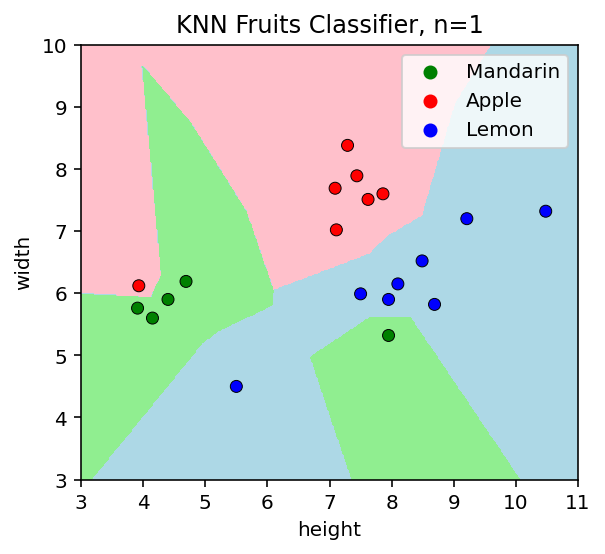

In [7]:
plotKNN(n_neighbors=1, 
        plot_height= df['height'], 
        plot_width = df['width'], 
        plot_labels=df.fruit.values)

We can remove the datapoints - after the learning is done, we don't need them anymore. Hence, we can set a parameter `plot_data=False` to see our trained model.

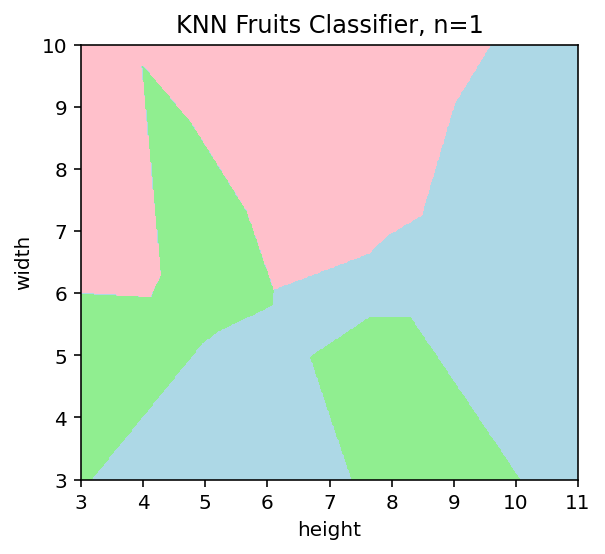

In [8]:
plotKNN(n_neighbors=1, plot_data=False)

### 3.3. Predict unknown values

Let's predict unknown fruits using our trained classifier. Let's try to predict the label for an unknown fruit with width of 9cm and height of 3cm

In [9]:
# Prediction for a single data point
clf.predict([[9, 3]])

array(['Mandarin'], dtype=object)

We can predict values for a whole bunch of them!

In [10]:
# Prediction for multiple data points
clf.predict([[9, 3], [4, 5], [2, 5], [8, 9], [5, 7]])

array(['Mandarin', 'Mandarin', 'Mandarin', 'Apple', 'Mandarin'],
      dtype=object)

## 4. How Good is our Prediction Function?

The next step is to evaluate how good our model is.

### 4.1. Evaluate on Train Set

Let's first evaluate the score of the model on the training dataset. Remember, as we explained in the MLS book, this should be 0 in this example. 
The first step is to "predict" the training set, that is, we pretend that we don't know its labels and see if the trained model manages to guess them correctly.

In [11]:
# Predict values for the training set
y_pred_train = clf.predict(X)

# Output of predicted labels
y_pred_train

array(['Mandarin', 'Apple', 'Lemon', 'Lemon', 'Lemon', 'Apple',
       'Mandarin', 'Mandarin', 'Lemon', 'Apple', 'Mandarin', 'Apple',
       'Lemon', 'Apple', 'Apple', 'Apple', 'Mandarin', 'Lemon', 'Lemon',
       'Lemon'], dtype=object)

Let's recall the actual labels for our fruits:

In [12]:
# Output of actual labels
y

array(['Mandarin', 'Apple', 'Lemon', 'Lemon', 'Lemon', 'Apple',
       'Mandarin', 'Mandarin', 'Lemon', 'Apple', 'Mandarin', 'Apple',
       'Lemon', 'Apple', 'Apple', 'Apple', 'Mandarin', 'Lemon', 'Lemon',
       'Lemon'], dtype=object)

Let's now calculate the difference between actual and predicted labels:

In [13]:
# Calculate the difference between actual values y and predicted values y_pred_train
train_score = metrics.accuracy_score(y, y_pred_train)

# Output
train_score

1.0

1.0 means the model correctly predicted all (100%) data points from the training set. We can calculate the misclassification error rate simply as:

In [14]:
train_error = 1-train_score

# Output
train_error

0.0

### 4.2. Evaluate on Test Set

Imagine we have new fuits with the following properties:

| height | width | fruit |
| ----------- | ----------- | ----------- |
| 4.0 | 6.5 | Mandarin |
| 4.47 | 7.13 | Mandarin |
| 6.49 | 7.0 | Apple |
| 7.51 | 5.01 | Lemon |
| 8.34 | 4.23 | Lemon |

Let's see if our model would correctly predict the fruit label from this dataset (test set). Again, we do so by showing fruits' measurements and not revealing their labels.

In [15]:
# Compose the Test set
test_data = pd.DataFrame({'height': [4, 4.47, 6.49, 7.51, 8.34],
                            'width': [6.5, 7.13, 7, 5.01, 4.23],
                            'fruit': ['Mandarin', 'Mandarin', 'Apple', 'Lemon', 'Lemon']})

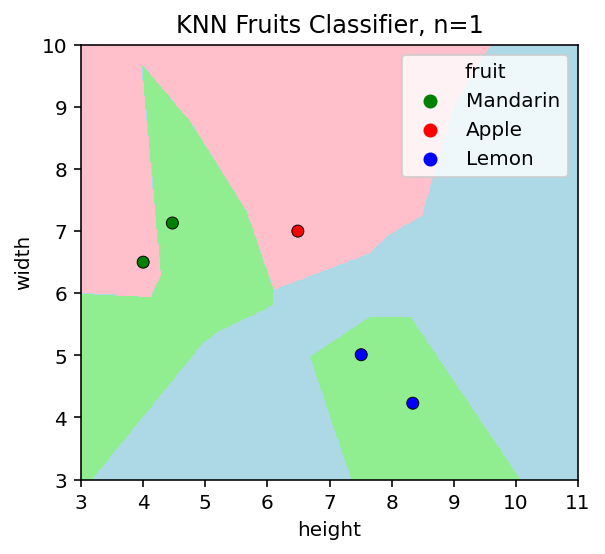

In [16]:
# Visualize the Test set on the trained model

plotKNN(n_neighbors=1, 
        plot_height=test_data.height,
        plot_width=test_data.width,
        plot_labels=test_data.fruit)

Just by eyeballing this graph, we can already see that the model made few prediction errors - some data points do not land at decision regions of the same color (this was explained in the book). Let's verify it:

In [17]:
# Predict observations
for i in range(len(test_data)):
    
    # Initialize the KNN model with 1 nearest neighbor
    clf = KNeighborsClassifier(n_neighbors = 1)

    # Define X and y using the dataset
    X = df[['height', 'width']].values
    y = df.fruit.values

    # Feed the dataset into the model to train
    clf.fit(X, y)
    
    pred = clf.predict([test_data.iloc[i, :-1]])
    
    if pred == test_data.fruit[i]:
        print(f'[CORRECT!] - actual observation is {test_data.fruit[i]}, and the model predicted {pred}')
    else:
        print(f'[WRONG!] - actual observation is {test_data.fruit[i]}, but the model predicted {pred}')

[WRONG!] - actual observation is Mandarin, but the model predicted ['Apple']
[CORRECT!] - actual observation is Mandarin, and the model predicted ['Mandarin']
[CORRECT!] - actual observation is Apple, and the model predicted ['Apple']
[WRONG!] - actual observation is Lemon, but the model predicted ['Mandarin']
[WRONG!] - actual observation is Lemon, but the model predicted ['Mandarin']


/Users/andrewwolf/Library/Caches/pypoetry/virtualenvs/themlsbook-8peXrHpY-py3.9/lib/python3.9/site-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)
/Users/andrewwolf/Library/Caches/pypoetry/virtualenvs/themlsbook-8peXrHpY-py3.9/lib/python3.9/site-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)
/Users/andrewwolf/Library/Caches/pypoetry/virtualenvs/themlsbook-8peXrHpY-py3.9/lib/python3.9/site-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being conve

The model incorrectly predicted 3 observations out of 5. As we discussed in the MLS book, when the error is low on the training set (0%), but much higher on an unseen test set (3/5=60%), the model is overfitted. Another problem is underfitting - when test and train errors are equally high. To get a balance between these two, we tune hyperparameters of the model to pick the right model complexity (not too simple, not too complicated).

## 5. Model Complexity

### 5.1. View Different Scenarios

Let's try different values of k (k=1, k=2, k-5, k=20) and visually see what happens.

#### 5.1.1. K = 1

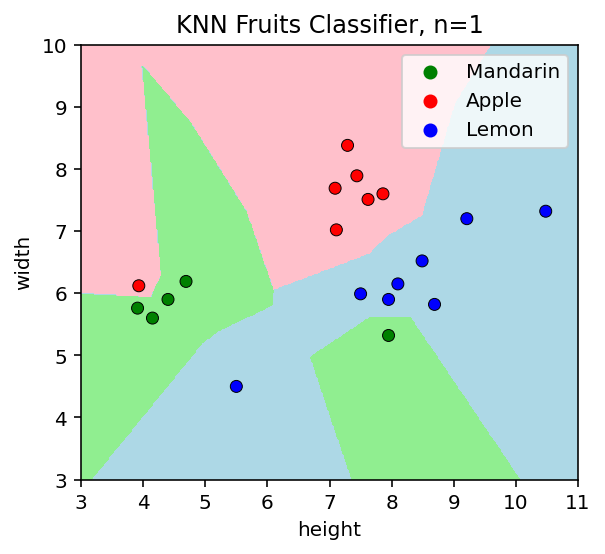

In [18]:
plotKNN(n_neighbors=1, #selecting k=1
        plot_height= df['height'], 
        plot_width = df['width'], 
        plot_labels=df.fruit.values)

Let's check predictions of test data once again:

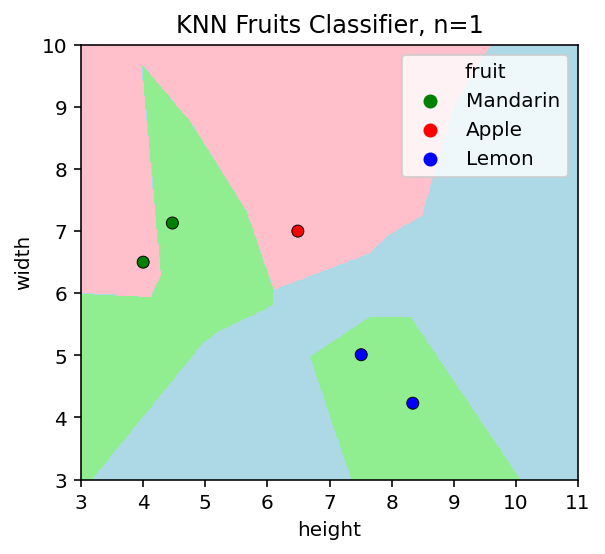

In [19]:
plotKNN(n_neighbors=1, 
        plot_height=test_data.height,
        plot_width=test_data.width,
        plot_labels=test_data.fruit)

Misclassifications on test set: 3 (3 data points do not have the same color as their decision region)

#### 5.1.2. K = 2

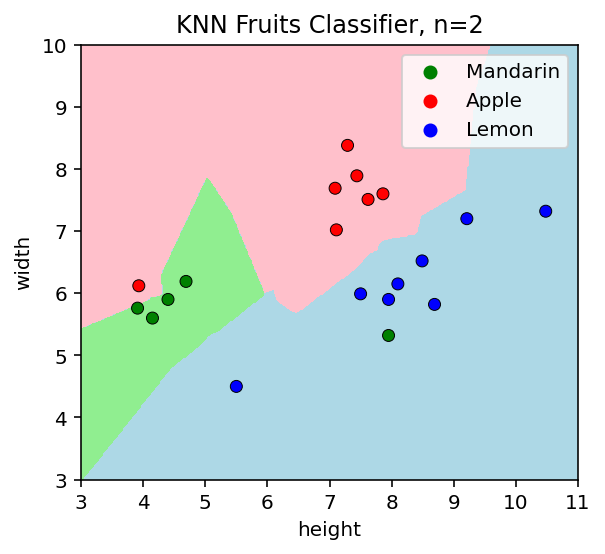

In [20]:
plotKNN(n_neighbors=2, #selecting k=2
        plot_height= df['height'], 
        plot_width = df['width'], 
        plot_labels=df.fruit.values)

Let's check predictions of test data when $k=2$:

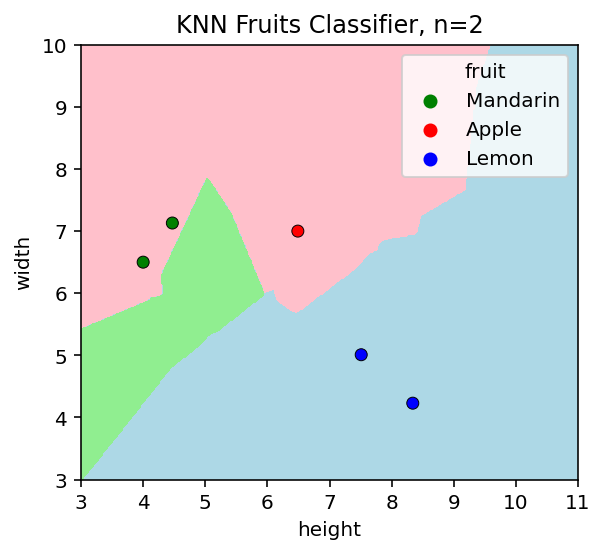

In [21]:
plotKNN(n_neighbors=2, 
        plot_height=test_data.height,
        plot_width=test_data.width,
        plot_labels=test_data.fruit)

Misclassifications on test set: 2 (2 data points (both mandarins) do not have the same color as their decision region)

#### 5.1.3. K = 5

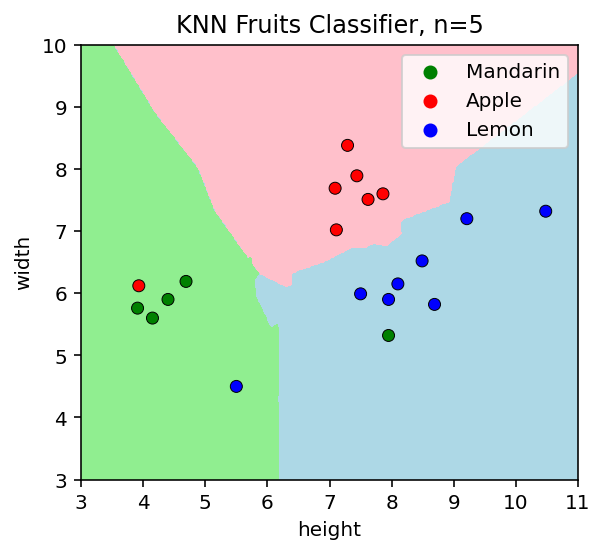

In [22]:
plotKNN(n_neighbors=5, #selecting k=5
        plot_height= df['height'], 
        plot_width = df['width'], 
        plot_labels=df.fruit.values)

Let's check predictions of test data when $k=5$:

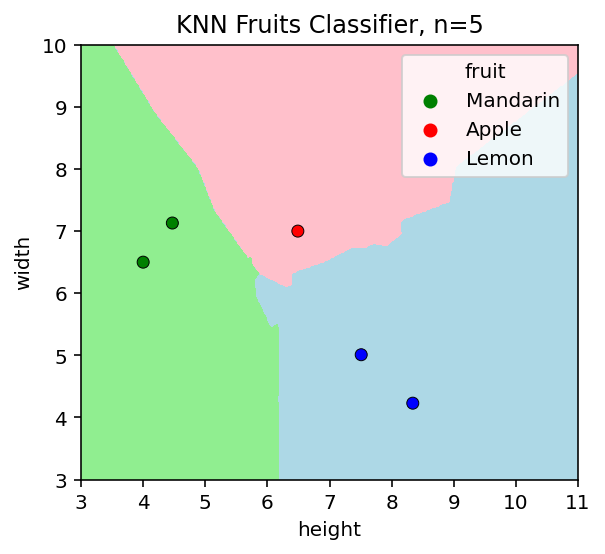

In [23]:
plotKNN(n_neighbors=5,
        plot_height=test_data.height,
        plot_width=test_data.width,
        plot_labels=test_data.fruit)

Misclassifications on test set: 0 (all data points have the same color as their decision region)

#### 5.1.4. K = N

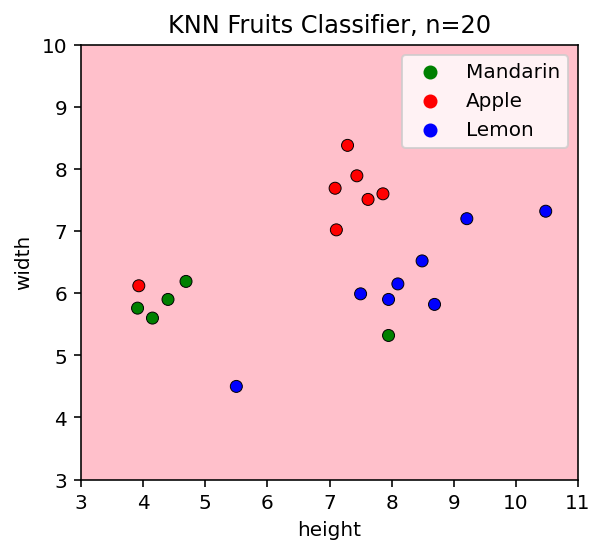

In [24]:
n = len(X)

plotKNN(n_neighbors=n, #selecting k=n=20
        plot_height= df['height'], 
        plot_width = df['width'], 
        plot_labels=df.fruit.values)

Let's check predictions of test data when $k=n=20$:

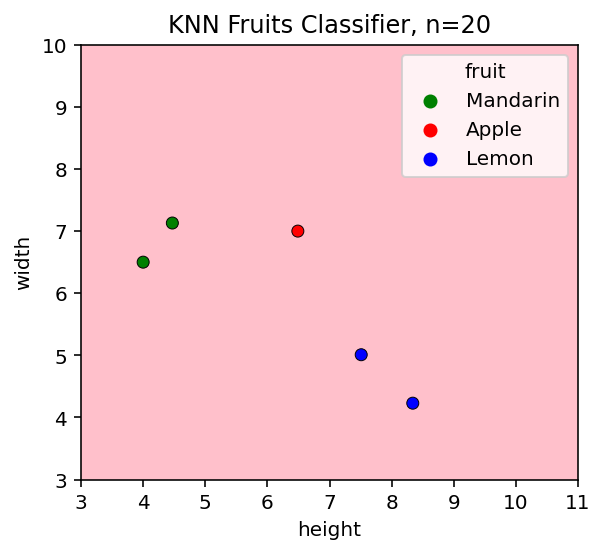

In [25]:
plotKNN(n_neighbors=n,
        plot_height=test_data.height,
        plot_width=test_data.width,
        plot_labels=test_data.fruit)

Misclassifications on test set: 4 (only one dataapoint (apple) has the same color as its decision region)

### 5.2. Tune Hyperparameters

Now, for each `k` let's calculate train_error and test_error.

In [26]:
# Define X and y using the dataset
X = df[['height', 'width']].values
y = df.fruit.values

train_errors = []
test_errors = []

k = []
test_misclassifications = []
train_misclassifications = []

for i in range(len(X)):
    _k = i+1
    
    # STEP 1: Again, initialize the model
    clf = KNeighborsClassifier(n_neighbors = _k)
    clf.fit(X, y)

    # STEP 2: make predictions on the test and train sets
    y_pred_train = clf.predict(X)
    y_pred_test = clf.predict(test_data[['height', 'width']])

    # STEP 4: Compare actual response values (y_train and y_test) with predicted response values (y_pred_train, y_pred_test)
    train_score = metrics.accuracy_score(y, y_pred_train)
    test_score = metrics.accuracy_score(test_data[['fruit']], y_pred_test)
    
    # STEP 5: Calculate train error and test error
    _train_error = round(1-train_score,2)
    _test_error = round(1-test_score,2)


    k.append(_k)
    train_errors.append(_train_error)
    test_errors.append(_test_error)
    
    print(f'k={_k} | train error: {train_errors[i]} | test error: {test_errors[i]} | train misclassifications: {_train_error*len(X)} | test misclassifications: {_test_error*len(test_data)}')
    
    

k=1 | train error: 0.0 | test error: 0.6 | train misclassifications: 0.0 | test misclassifications: 3.0
k=2 | train error: 0.05 | test error: 0.4 | train misclassifications: 1.0 | test misclassifications: 2.0
k=3 | train error: 0.15 | test error: 0.0 | train misclassifications: 3.0 | test misclassifications: 0.0
k=4 | train error: 0.15 | test error: 0.0 | train misclassifications: 3.0 | test misclassifications: 0.0
k=5 | train error: 0.15 | test error: 0.0 | train misclassifications: 3.0 | test misclassifications: 0.0
k=6 | train error: 0.15 | test error: 0.0 | train misclassifications: 3.0 | test misclassifications: 0.0
k=7 | train error: 0.15 | test error: 0.0 | train misclassifications: 3.0 | test misclassifications: 0.0
k=8 | train error: 0.15 | test error: 0.0 | train misclassifications: 3.0 | test misclassifications: 0.0
k=9 | train error: 0.15 | test error: 0.2 | train misclassifications: 3.0 | test misclassifications: 1.0
k=10 | train error: 0.15 | test error: 0.4 | train miscl

/Users/andrewwolf/Library/Caches/pypoetry/virtualenvs/themlsbook-8peXrHpY-py3.9/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Users/andrewwolf/Library/Caches/pypoetry/virtualenvs/themlsbook-8peXrHpY-py3.9/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Users/andrewwolf/Library/Caches/pypoetry/virtualenvs/themlsbook-8peXrHpY-py3.9/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Users/andrewwolf/Library/Caches/pypoetry/virtualenvs/themlsbook-8peXrHpY-py3.9/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Users/andrewwolf/Library/Caches/pypoetry/virtua

### 5.3. Plot Misclassification Error Rates 

Now, let's plot a graph that shows misclassification error rate for training and test sets as we vary $k$, the number of neighbors in our KNN model.

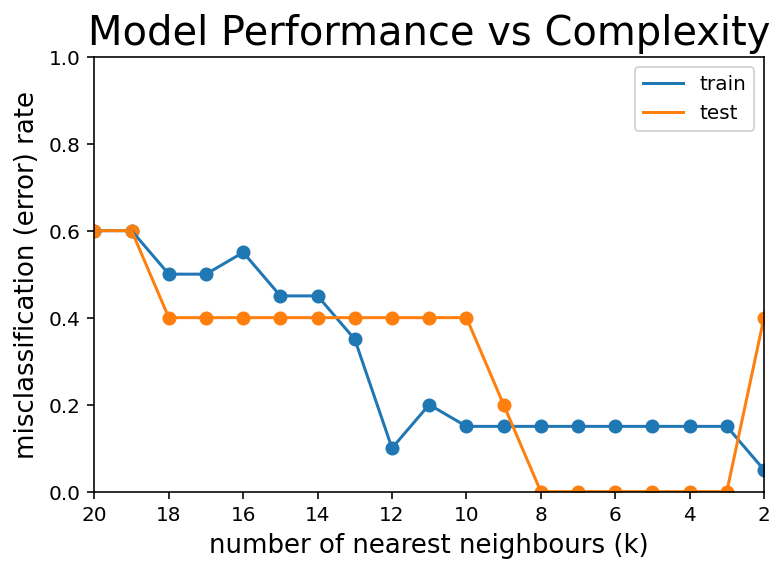

In [27]:
# Plot train error rates
plt.scatter(k, train_errors) #function
plt.plot(k, train_errors, '-', label='train') #data points

# Plot test error rates
plt.scatter(k, test_errors) #function
plt.plot(k, test_errors, '-', label='test') #data points

# Plot configurations
plt.axis([max(k),min(k)+1, 0, 1])
plt.xlabel('number of nearest neighbours (k)', size = 13)
plt.ylabel('misclassification (error) rate', size = 13)
plt.title('Model Performance vs Complexity', size = 20)
plt.legend()

# Output
plt.show()

Models on the left side of the plot (near $k=n=20$) use too large a neighborhood and produce an underfit model. Models on the right side of the plot (near $k=1$) use too small a neighborhood and produce an overfit model. Models between $k=3$ and $k=7$ perform optimally on the test set -- in other words, they optimally balance overfitting and underfitting.